In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import matplotlib
from wordcloud import WordCloud
from nltk.corpus import stopwords
%matplotlib inline
plt.style.use('seaborn')

# DataFrame

In [2]:
us = pd.read_csv('../data/us_kickstarter.zip')

In [3]:
film = us[us['category'] == 'film & video']

# Word Cloud

In [4]:
def create_wordcloud(contents):
    wc = WordCloud(
    background_color="white",
    max_words=200,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
    )

    # Generate the cloud

    wc.generate(contents)

    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    

In [5]:
all_contents = " ".join(film['blurb'].fillna("").tolist())

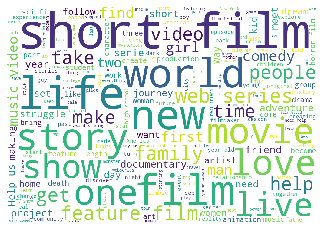

In [6]:
create_wordcloud(all_contents)

## Successful

In [7]:
contents = " ".join(film[film['state'] == 'successful']['blurb'].fillna("").tolist())

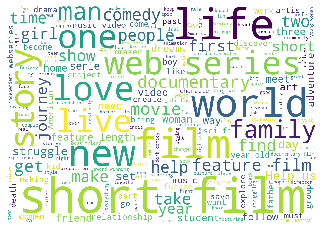

In [8]:
create_wordcloud(contents)

In [9]:
failure = " ".join(film[(film['state'] != 'successful') & \
                              (film['state'] != 'live') ]['blurb'].fillna("").tolist())

failure = " ".join(film[film['state'] == 'failed']['blurb'].fillna("").tolist())

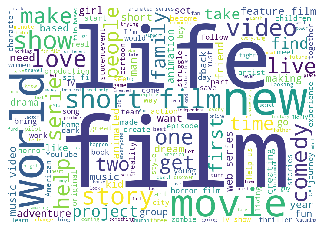

In [10]:
create_wordcloud(failure)

# Random Forest

In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from copy import copy
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from copy import copy


In [12]:
features_to_select = ['category_parent_id', 'days_to_deadline', 'staff_pick', \
                 'location_type', 'location_state', 'location_id', 'goal', \
                  'launched_weekday', 'description_length', 'is_weekend_launch', \
                 'launched_week', 'launched_month']


In [13]:
df = copy(film)

In [14]:
## remove live projects
df = df[df['state'] != 'live']

In [15]:
### successful, not successful
df['state'] = np.where(df['state'] == 'successful', 1, 0)

In [16]:
target = df['state']
df = df[features_to_select]

In [17]:
df['category_parent_id'] = df['category_parent_id'].fillna(0)

In [18]:
def set_dummies(df):
    # state
    states = pd.get_dummies(df['location_state'], prefix='_')
    df = df.join(states)
    df.drop('location_state', axis = 1)
    
    # type
    types = pd.get_dummies(df['location_type'], prefix='_')
    df = df.join(types)
    df.drop('location_type', axis=1)
    
    return df

In [19]:
df = set_dummies(df)

In [20]:
df.drop('location_type', axis=1, inplace=True)

In [21]:
df.drop('location_state', axis=1, inplace=True)

In [22]:
def train_model(Xtrain, ytrain):
    rf = RandomForestClassifier(n_estimators = 10, max_depth = 10 )
    rf.fit(Xtrain, ytrain)
    
    score = rf.score(Xtrain, ytrain)
    
    return rf, score
    

In [23]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df, target, test_size=0.3, random_state=42)

In [24]:
to_scale = ['goal', 'description_length', 'days_to_deadline']

In [25]:
scaler = StandardScaler()

In [26]:
Xtrain.loc[:,to_scale] = scaler.fit_transform(Xtrain[to_scale])

C:\Users\sahil\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size = 0.4, random_state=42)

In [28]:
rf, score = train_model(Xtrain, ytrain)

In [29]:
score

0.7389056783839669

In [30]:
Xval.loc[:, to_scale] = scaler.transform(Xval[to_scale])

In [31]:
rf.score(Xval, yval)

0.6931642437364677

# Bagging Model

In [32]:
bagging = BaggingClassifier()

bagging.fit(Xtrain, ytrain)

bagging.score(Xtrain, ytrain)

0.9836169874343884

In [33]:
bagging.score(Xval, yval)

0.663161150634086

# Grid Search

In [34]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'n_estimators':(10, 20, 30), #the number of trees
     'max_depth':(8,10,15, 20)
}

model = GridSearchCV(RandomForestClassifier(),parameters,cv=3,iid=False)
model.fit(Xtrain, np.ravel(ytrain))
model.best_score_, model.best_params_

(0.704867391229115, {'max_depth': 20, 'n_estimators': 30})

In [35]:
model.score(Xval, yval)

0.6953294154036499